In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Callable, Dict, List, Tuple


In [3]:
import random

def bandit_factory(mu=0, sigma=1, random_width=1):
    """
    Creates and returns a bandit function and its parameters. The bandit function,
    when called, generates a random number from a normal distribution with
    the mean (`mu_bandit`) and standard deviation (`sigma_bandit`) determined at the
    creation of the bandit. The mean of the bandit is itself a random variable
    drawn from a normal distribution with mean `mu` and standard deviation `sigma`.

    Parameters:
    - mu (float): The mean of the normal distribution used to generate the bandit's mean. Defaults to 0.
    - sigma (float): The standard deviation of the normal distribution used to generate the bandit's mean. Defaults to 1.
    - random_width (float): The standard deviation (sigma_bandit) of the bandit's normal distribution used to generate rewards. Defaults to 1.

    Returns:
    - inner (function): The bandit function that generates rewards.
    - mu_bandit (float): The mean of the bandit's normal distribution.
    - sigma_bandit (float): The standard deviation of the bandit's normal distribution.
    """
    mu_bandit = random.normalvariate(mu, sigma)
    sigma_bandit = random_width

    def inner():
        """Generates a random reward based on the bandit's distribution."""
        return random.normalvariate(mu_bandit, sigma_bandit)

    return inner, mu_bandit, sigma_bandit


In [4]:
def plot_bandits(bandits):
    l = len(bandits)
    data = pd.DataFrame({
        'bandit': np.repeat(range(l),1000),
        'value': np.concatenate([[b() for i in range(1000)] for b in bandits])
    })
    sns.violinplot(x='bandit', y='value', data=data)
    plt.title('Violin plot of several distributions')
    plt.xlabel('Category')
    plt.ylabel('Value')
    
    plt.show()

In [5]:
number_of_bandits = 10
b = [bandit_factory(sigma=1) for i in range(number_of_bandits)]
bandits = [x[0] for x in b]
mus = [x[1] for x in b]
mus

[-2.3180281108340197,
 -1.0838598247837479,
 0.39162503028378887,
 -0.5509090485297784,
 1.2572573048723703,
 0.5064260205731449,
 -1.9556875041511659,
 0.051303911959743445,
 0.6101578275632809,
 0.35279000759124185]

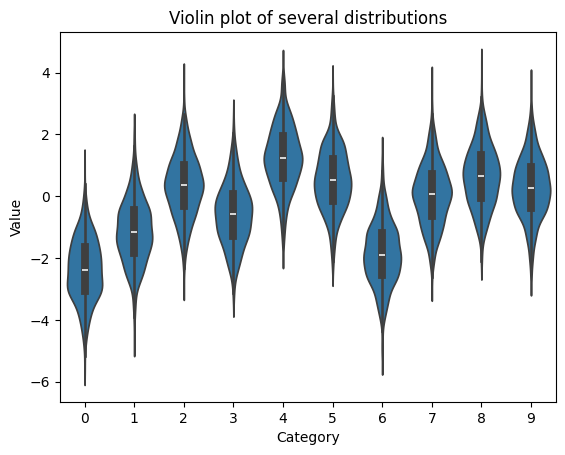

In [6]:
plot_bandits(bandits)

In [7]:
def uniform_policy(Q):
    """ 
    Given a policy array Q mapping actions to values, select an action uniformly
    at random 
    """
    return random.sample(range(len(Q)),k=1)[0]

def weighted_policy(Q):
    """ 
    Given a policy array Q mapping actions to values, select an action at random
    according to a probability distribution based on the values in Q
    """
    return random.choices(range(len(Q)), weights=Q, k=1)[0]

def greedy_policy(Q):
    """ 
    Given a policy array Q mapping actions to values, select the action
    witht the highest value, breaking ties randomly
    """
    return max(enumerate(Q), key = lambda x: (x[1],random.random()))[0] # maxarg of Q

def fixed_policy_factory(k):
    """ 
    Return a policy function. The function policy will always yield the
    index 'k' as the selected action.
    """
    def inner(Q):
        return k
    return inner

In [8]:
def play_out(bandits, policy, Q, trials):
    """
    Simulates the playing out of a multi-armed bandit problem over a specified number of trials,
    using a given policy to select which bandit arm to play. The function calculates the average
    reward obtained by following the policy over all trials.

    This function represents a core part of the learning algorithm's interaction with the
    environment, allowing it to evaluate the effectiveness of a policy based on empirical rewards.

    Parameters:
    - bandits (list of functions): A list where each element is a function representing a bandit arm.
                                   Calling a bandit function simulates pulling that arm and returns
                                   a reward.
    - policy (function): A function that decides which bandit arm to pull next, based on the current
                         mapping from action to values (Q). The policy function takes Q as an argument and
                         returns the index of the bandit arm to pull.
    - Q (list): A data structure representing the current state of knowledge about the
                        rewards of each bandit arm. It is a list and Q[i] = value of action[i]
    - trials (int): The number of trials to simulate. Each trial involves using the policy to select
                    an arm, pulling that arm, and receiving a reward.

    Returns:
    - float: The average reward obtained by following the policy over the specified number of trials.
             This value serves as an empirical measure of the policy's effectiveness.
    """
    reward = 0
    for i in range(trials):
        # Use the policy to select a bandit arm and simulate pulling that arm
        reward += bandits[policy(Q)]()
    # Calculate and return the average reward per trial
    return reward / trials


In [24]:
import random

def bandit_learn_1(bandits: List[Callable[[], float]], 
                   trials: int, 
                   **kwargs: float) -> Tuple[List[float], List[float]]:
    """
    Performs a simple learning algorithm on a set of bandit arms over a specified number of trials.
    The algorithm uses an epsilon-greedy policy for action selection, balancing exploration and
    exploitation based on the value of epsilon.

    Parameters:
    - bandits (list of functions): A list of bandit arms, where each bandit arm is represented by a
                                   function that returns a reward when called.
    - trials (int): The number of trials to run the learning algorithm. Each trial involves selecting
                    an arm to pull based on the current policy, receiving a reward, and updating
                    knowledge accordingly.
    - **kwargs: Additional keyword arguments. This implementation expects 'epsilon' to be provided,
                which determines the probability of selecting an action at random (exploration)
                versus selecting the best-known action (exploitation).

    Returns:
    - Q (list): The final estimated values of each action, where each value is an estimation of
                the expected reward for taking that action. Higher values indicate more promising actions.
    - R_history (list): The history of average rewards received up to each trial. This provides
                        insight into how the algorithm's performance evolves over time.

    Note:
    The function assumes that `uniform_policy` selects an action uniformly at random and
    `greedy_policy` selects the action with the highest value in Q. Both policies are expected
    to return the index of the selected action.
    """
    epsilon = kwargs.get('epsilon', 0.1)  # Default value if epsilon not provided
    k = len(bandits)
    Q = [0] * k  # Initialize estimated values
    N = [0] * k  # Initialize action selection counts
    R_total = 0  # Total reward
    n = 0  # Total number of selections
    R_history = []  # History of average rewards

    while trials > 0:
        # Action selection based on epsilon-greedy policy
        if random.random() < epsilon:
            action = uniform_policy(Q)  # Exploration
        else:
            action = greedy_policy(Q)  # Exploitation

        R = bandits[action]()  # Simulate pulling the selected arm
        R_total += R
        n += 1
        R_history.append(R_total / n)  # Update average reward history
        N[action] += 1  # Increment selection count for the chosen action
        # Update estimated value for the selected action
        Q[action] += 1 / N[action] * (R - Q[action])
        trials -= 1

    return Q, R_history


In [25]:
import random

def bandit_learn_2(bandits, trials, **kwargs):
    """
    Implements a learning algorithm for a set of bandit arms using a simplified
    gradient ascent update rule. The algorithm applies an epsilon-greedy policy for
    action selection, allowing for both exploration of new actions and exploitation of
    known actions based on their estimated values. The value of an action is updated
    using a fixed step size (alpha) in the direction that would maximize expected rewards,
    which is a characteristic of gradient ascent methods.

    Parameters:
    - bandits (list of functions): A list of bandit arms, where each bandit arm is represented
                                   by a function that returns a reward when called.
    - trials (int): The number of trials to run the algorithm. Each trial involves selecting an
                    arm to pull based on the epsilon-greedy policy, receiving a reward, and updating
                    the estimated values of actions accordingly.
    - **kwargs: Additional keyword arguments, specifically:
        - alpha (float): The step size used in the value update rule. This parameter controls
                         the rate of learning; a larger alpha results in faster updates.
        - epsilon (float): The probability of choosing an action at random rather than the
                           best-known action, facilitating exploration.

    Returns:
    - Q (list): The final estimated values of each action, related to the expected rewards for
                taking those actions. Actions with higher values are considered more promising.
    - R_history (list): A record of the average rewards obtained up to each trial, offering
                        insights into the algorithm's performance and learning progress over time.

    Note:
    The function relies on `uniform_policy` for selecting an action uniformly at random (exploration)
    and `greedy_policy` for selecting the action with the highest value (exploitation). These policies
    should return the index of the chosen action.
    """
    alpha = kwargs.get('alpha', 0.1)  # Default learning rate if not provided
    epsilon = kwargs.get('epsilon', 0.1)  # Default exploration rate if not provided
    k = len(bandits)
    Q = [0] * k  # Initialize action value estimates
    N = [0] * k  # Initialize action selection counts
    R_total = 0  # Total accumulated reward
    n = 0  # Total number of actions taken
    R_history = []  # History of average rewards

    while trials > 0:
        # Decide whether to explore or exploit based on epsilon
        if random.random() < epsilon:
            action = uniform_policy(Q)  # Explore
        else:
            action = greedy_policy(Q)  # Exploit

        R = bandits[action]()  # Receive reward for chosen action
        R_total += R
        n += 1
        R_history.append(R_total / n)  # Update average reward history
        N[action] += 1  # Increment count for the selected action
        # Update the action value estimate using the simplified gradient ascent rule
        Q[action] += alpha * (R - Q[action])
        trials -= 1

    return Q, R_history


In [26]:
import numpy as np

def bandit_learn_ucb(bandits, trials, **kwargs):
    """
    Implements the Upper Confidence Bound (UCB) algorithm for the multi-armed bandit problem.
    This approach balances exploration and exploitation by selecting actions based on their
    estimated values and the uncertainty or variance in those estimates. The UCB algorithm
    adds a confidence bound term to the estimated action values, encouraging exploration of
    actions with fewer trials or higher uncertainty.

    Parameters:
    - bandits (list of functions): A list of bandit arms, where each arm is represented by a
                                   function that simulates pulling the arm and returns a reward.
    - trials (int): The number of trials to run the algorithm. Each trial involves selecting an
                    arm based on the UCB policy, receiving a reward, and updating the action
                    values and confidence bounds.
    - **kwargs: Additional keyword arguments, specifically:
        - c (float): The exploration parameter used in the UCB calculation. A higher value
                     increases the tendency to explore less tried arms.

    Returns:
    - Q (numpy array): The final estimated values of each action, indicating the expected rewards
                       for taking those actions. Actions with higher values are considered more promising.
    - R_history (list): A record of the average rewards obtained up to each trial, providing insights
                        into the algorithm's performance and learning progress over time.

    Note:
    The function uses `greedy_policy` for selecting the action with the highest upper confidence bound.
    This policy should return the index of the chosen action. The `Q` values are adjusted based on the
    received rewards and the number of times each action has been selected, factored into the UCB calculation.
    """
    c = kwargs.get('c', 1.0)  # Default exploration factor if not provided
    k = len(bandits)
    Q = np.array([0.] * k)  # Initialize action value estimates
    N = np.array([0.] * k)  # Initialize action selection counts
    R_total = 0  # Total accumulated reward
    n = 0  # Total number of actions taken
    R_history = []  # History of average rewards

    while trials > 0:
        n += 1
        # Calculate upper confidence bounds for all actions
        q = Q + c * np.sqrt(np.log(n) / (N + 1e-10))
        action = greedy_policy(q)  # Select action with highest UCB
        R = bandits[action]()  # Receive reward for chosen action
        R_total += R
        R_history.append(R_total / n)  # Update average reward history
        N[action] += 1  # Increment count for the selected action
        # Update the estimated action value
        Q[action] += 1 / N[action] * (R - Q[action])
        trials -= 1

    return Q, R_history


In [30]:
def aggregate_bandit_learn(learn_fn, bandits, trials, aggregate_steps, **kwargs):
    q,r_total = learn_fn(bandits, trials, **kwargs)
    r_total = np.array(r_total)
    for i in range(aggregate_steps):
        q, r = learn_fn(bandits, trials, **kwargs)
        r = np.array(r)
        r_total = np.vstack((r_total, r))
    return np.mean(r_total, axis = 0)

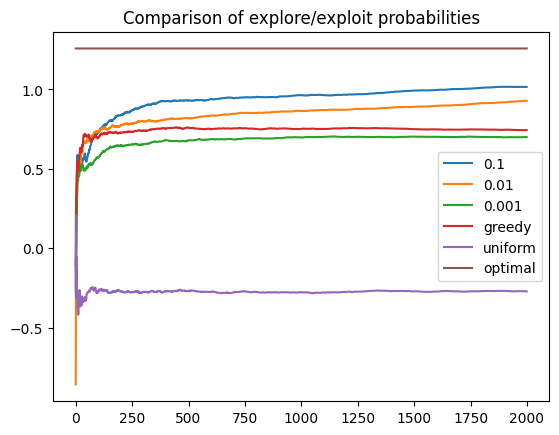

In [33]:
trials = 2000
reps = 10

def aggregate_bandit_learn_1(**kwargs):
    return aggregate_bandit_learn(bandit_learn_1, bandits, trials, reps, **kwargs)
    
plt.plot(aggregate_bandit_learn_1(epsilon=0.1), label = '0.1')
plt.plot(aggregate_bandit_learn_1(epsilon=0.01), label = '0.01')
plt.plot(aggregate_bandit_learn_1(epsilon=0.001), label = '0.001')
plt.plot(aggregate_bandit_learn_1(epsilon=0), label = 'greedy')
plt.plot(aggregate_bandit_learn_1(epsilon=1), label = 'uniform')
plt.plot([np.max(mus)]*trials, label = 'optimal')
plt.title("Comparison of explore/exploit probabilities")
plt.legend()
plt.show()

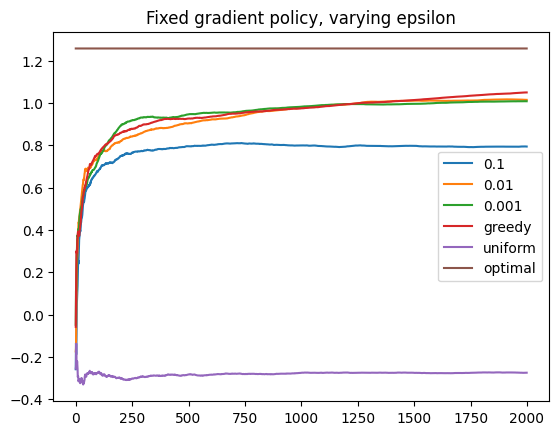

In [14]:
trials = 2000
reps = 50
alpha = 0.7

def aggregate_bandit_learn_2(**kwargs):
    return aggregate_bandit_learn(bandit_learn_2, bandits, trials, reps, **kwargs)

plt.plot(aggregate_bandit_learn_2(alpha=alpha, epsilon=0.1), label = '0.1')
plt.plot(aggregate_bandit_learn_2(alpha=alpha, epsilon=0.01), label = '0.01')
plt.plot(aggregate_bandit_learn_2(alpha=alpha, epsilon=0.001), label = '0.001')
plt.plot(aggregate_bandit_learn_2(alpha=alpha, epsilon=0), label = 'greedy')
plt.plot(aggregate_bandit_learn_2(alpha=alpha, epsilon=1), label = 'uniform')
plt.plot([np.max(mus)]*trials, label = 'optimal')
plt.title("Fixed gradient policy, varying epsilon")
plt.legend()
plt.show()

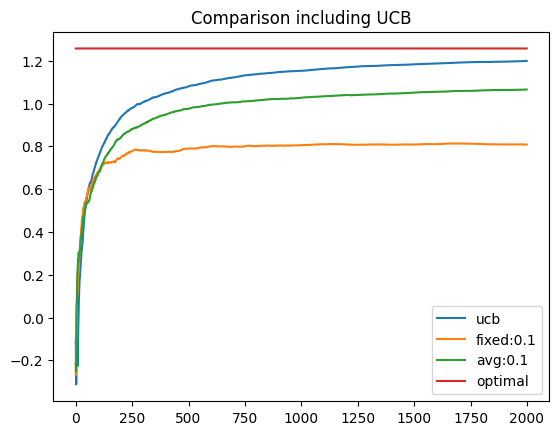

In [16]:
count = 2000
trials = 2000
reps = 50
alpha = 0.7

def aggregate_bandit_learn_3(**kwargs):
    return aggregate_bandit_learn(bandit_learn_ucb, bandits, trials, reps, **kwargs)
  
plt.plot(aggregate_bandit_learn_3(c=1.5), label = 'ucb')
plt.plot(aggregate_bandit_learn_2(alpha=alpha, epsilon=0.1), label = 'fixed:0.1')
plt.plot(aggregate_bandit_learn_1(alpha=alpha, epsilon=0.1), label = 'avg:0.1')

plt.plot([np.max(mus)]*count, label = 'optimal')
plt.legend()
plt.title("Comparison including UCB")
plt.show()